# Testing Planetary Computer python library

The Microsoft Planetary Computer is a platform that lets users leverage the power of the cloud to accelerate environmental sustainability and Earth science.
<br>
The Planetary Computer consists of four major components:<br>
- Data Catalog
- APIs
- Hub
- Applications

All documentation is at follow <a href="https://planetarycomputer.microsoft.com/docs/overview/about/" target="_blank"></a>

Here is how we can access at simple Sentinel 2 data:

In [1]:
import pystac
import planetary_computer
import rioxarray
import matplotlib.pyplot as plt
import numpy as np

item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20220719T095559_R122_T33TVF_20220719T204024"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)
signed_item = planetary_computer.sign(item)

# Open one of the data assets (other asset keys to use: 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP', 'visual')
asset_href = signed_item.assets["visual"].href
img = rioxarray.open_rasterio(asset_href).transpose("y","x","band")

In [2]:
img

<xarray.DataArray (y: 10980, x: 10980, band: 3)>
[361681200 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1 2 3
  * x            (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.098e+05
  * y            (y) float64 4.6e+06 4.6e+06 4.6e+06 ... 4.49e+06 4.49e+06
    spatial_ref  int32 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

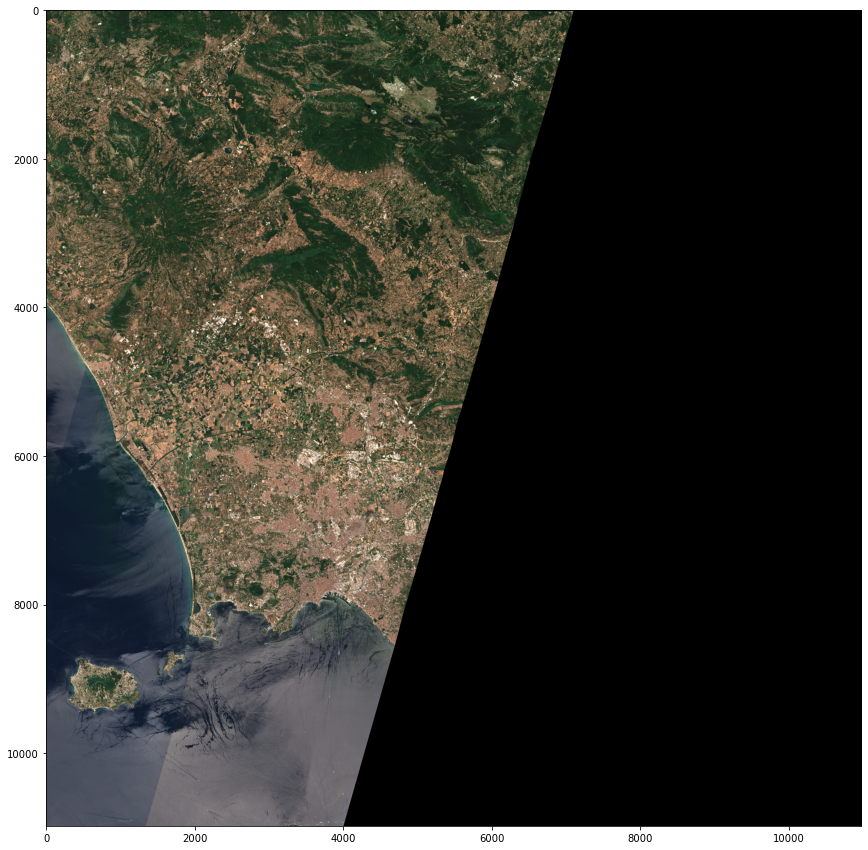

In [3]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.imshow(img)
plt.show()

## NDVI calculation by using B4 and B8 band

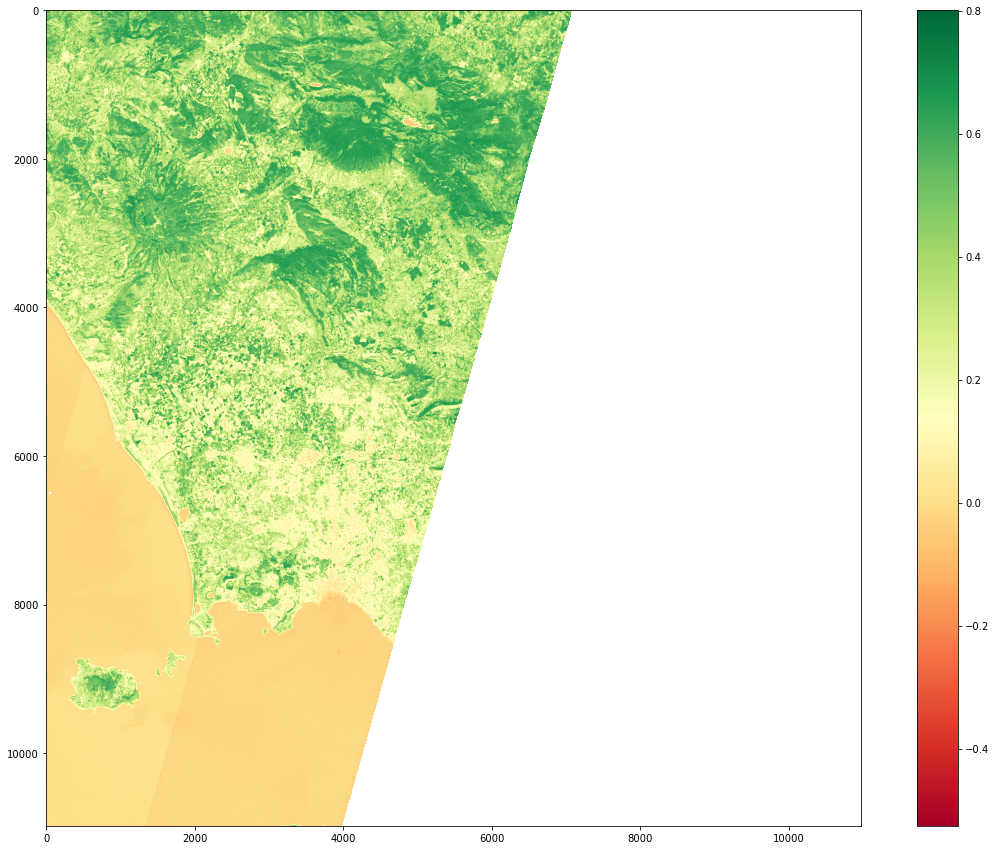

In [4]:
# Open one of the data assets (other asset keys to use: 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP', 'visual')
b4 = signed_item.assets["B04"].href
b4 = rioxarray.open_rasterio(b4).transpose("y","x","band").astype('float64')

b8 = signed_item.assets["B08"].href
b8 = rioxarray.open_rasterio(b8).transpose("y","x","band").astype('float64')

ndvi=(b8-b4)/(b8+b4)

#in order to use legend bar we need a mappable object for colorbar

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ndvi_mappable=ax.imshow(ndvi,cmap='RdYlGn')
fig.colorbar(ndvi_mappable)
plt.show()


## A different RGB visualization by combining B2, B3, B4 bands

In [5]:
# Open one of the data assets (other asset keys to use: 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP', 'visual')
b2 = signed_item.assets["B02"].href
blue = rioxarray.open_rasterio(b2).transpose("y","x","band").astype('float64')

b3 = signed_item.assets["B03"].href
green = rioxarray.open_rasterio(b3).transpose("y","x","band").astype('float64')

b4 = signed_item.assets["B04"].href
red = rioxarray.open_rasterio(b4).transpose("y","x","band").astype('float64')


# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

rgb = np.dstack((redn,greenn,bluen))

### Analize RGB histogram to recovery the just range where main information is.
I want to discover where the main information data is, as I know data is in a range [0,1], I start displaying an histogram where rgb<1 

(array([2.86480045e+08, 7.42300890e+07, 8.98597000e+05, 5.82800000e+04,
        1.02380000e+04, 2.34700000e+03, 7.90000000e+02, 3.46000000e+02,
        1.96000000e+02, 2.65000000e+02]),
 array([0.        , 0.09991158, 0.19982317, 0.29973475, 0.39964633,
        0.49955791, 0.5994695 , 0.69938108, 0.79929266, 0.89920424,
        0.99911583]),
 <BarContainer object of 10 artists>)

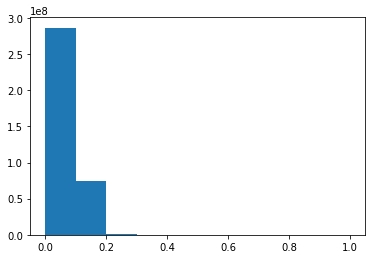

In [6]:
plt.hist(rgb[rgb<1])

All data are in a range between 0.0 and 0.2. 
By observing the formula in (*), I'm going to define a brightness_contrast function where rgb, alfa, beta values are passed. So, from (*) we find the best alfa and beta values for brightness and contrast.

In [18]:
def brightness_contrast(rgb,alfa,beta):
    image=rgb*alfa+beta
    image[image>1]=1
    image[image<0]=0
    return image

I find the best alfa and beta values for brightness and contrast as written in (*) in order to give an automatic way for these parameters:

In [19]:
alfa=1/(rgb[rgb<0.2].max()-rgb[rgb>0].min())
beta=-rgb[rgb>0].min()*alfa

alfa,beta

(5.0029726163833335, -0.00026276116682685574)

Here define a display function for showing the image with given alfa and beta:

In [20]:
def displayImage(image,alfa,beta):
    fig = plt.figure(figsize=(20,15))
    ax = fig.add_subplot(111)
    ax.imshow(image)
    plt.title('Alfa='+str(alfa)+' & Beta='+str(beta))
    plt.show()

- RGB image by launching the functions:

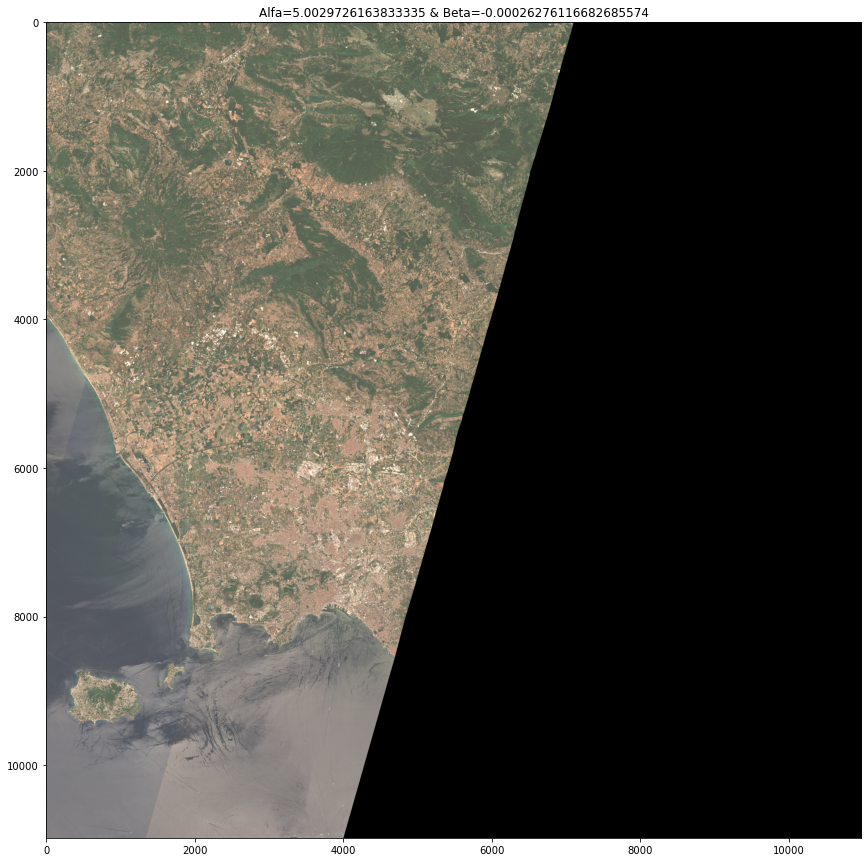

In [21]:
image = brightness_contrast(rgb,alfa,beta)
displayImage(image,alfa,beta)

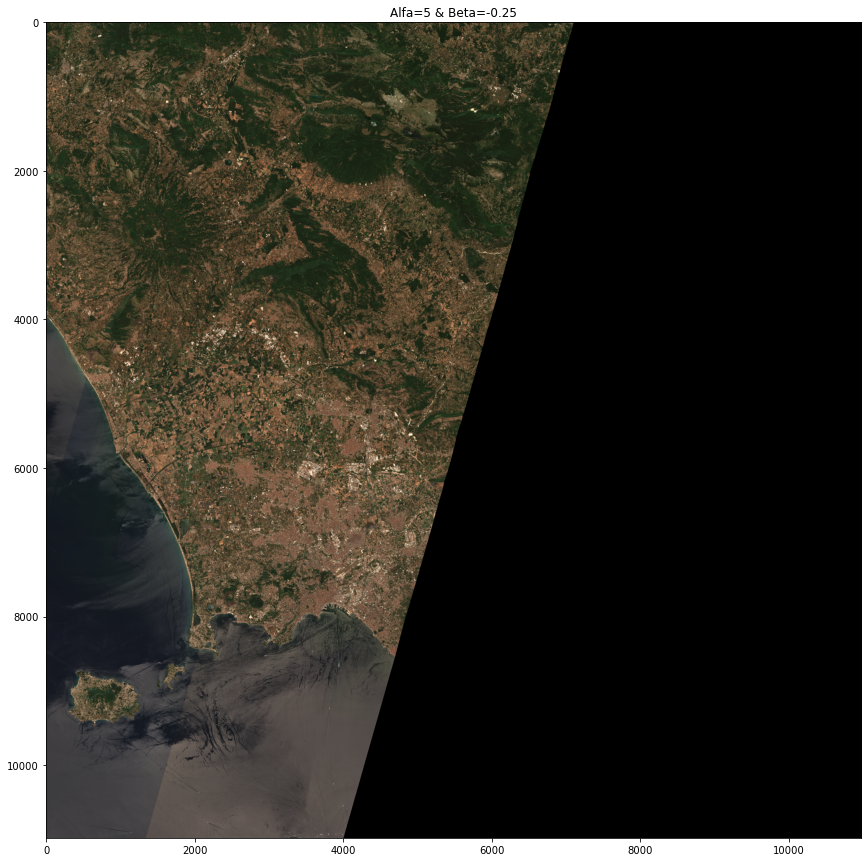

In [22]:
image=brightness_contrast(rgb,alfa=5,beta=-0.25)
displayImage(image,alfa=5,beta=-0.25)

With a Beta contrast at -0.25 we obtain a darker image than previous one.

## Clip a Planetary Computer Image by using a region of interest in geojson format

The aim is to clip our image with region of interest whom I create in  a geojson file. <br>
First of all we need Geopandas libraries to manage geojson.

In [21]:
import geopandas as gpd

- Reading geojson file and visualize it

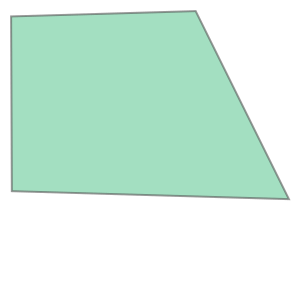

In [45]:
roi = gpd.read_file('roi.geojson')
roi['geometry'][0]

In [24]:
roi.geometry

0    POLYGON ((400368.412 4513957.026, 400413.355 4...
Name: geometry, dtype: geometry

To clip the image we need that our roi and the image to cut are in the same crs. <br> As we can discover it by querying the proj:epsg properties of Pystac Item, created at beginning of this notebook.

In [25]:
item.properties["proj:epsg"]

32633

The EPSG crs is 32633, that's why I created my roi.geojson in that crs. <br> So, now, I am able to apply the clip at "visual" planetary computer product (img)

In [26]:
clipped_img = img.rio.clip(roi.geometry)

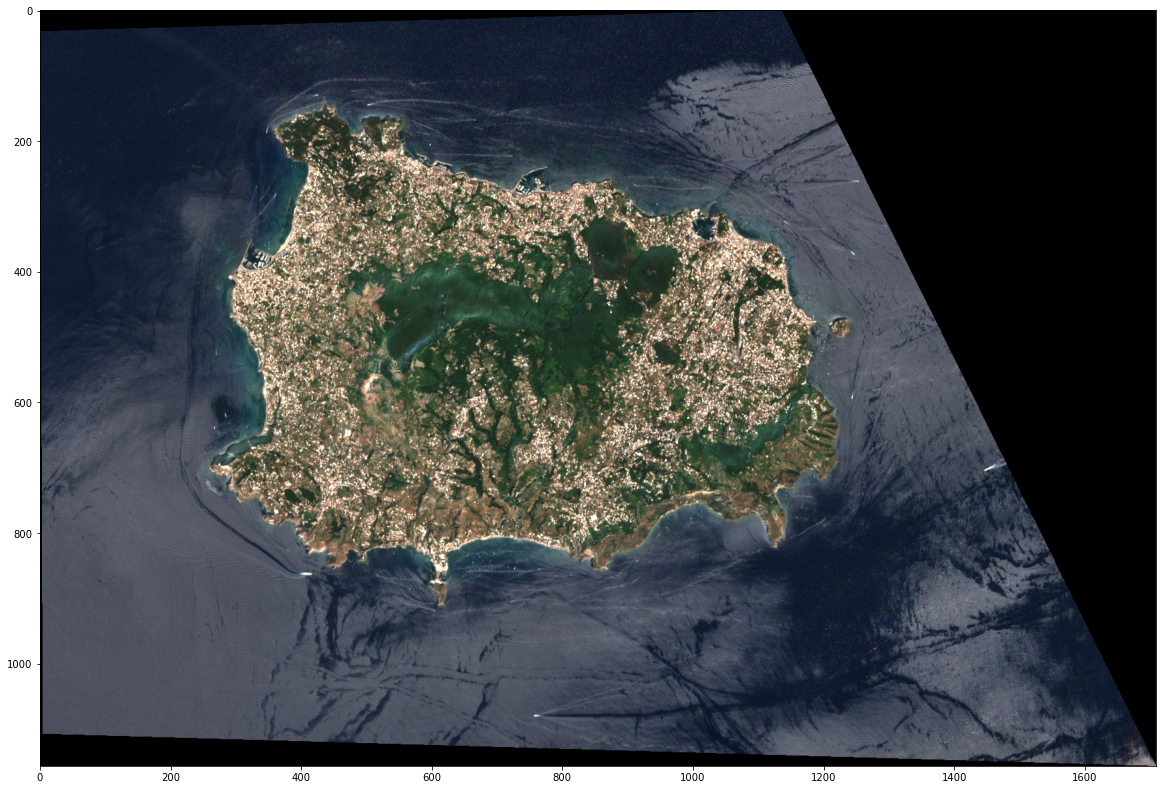

In [27]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.imshow(clipped_img)
plt.show()

I want to apply the same process at the different RGB visualization as created before. Being the image as an np.array,firstly I need to convert that in an xarray object, having as data the image data and coords, dims and attrs the same of img.

In [40]:
import xarray as xr

In [41]:
image_to_clip = xr.DataArray(image.data, img.coords, img.dims, img.attrs)

In [42]:
clipped_img = image_to_clip.rio.clip(roi.geometry)

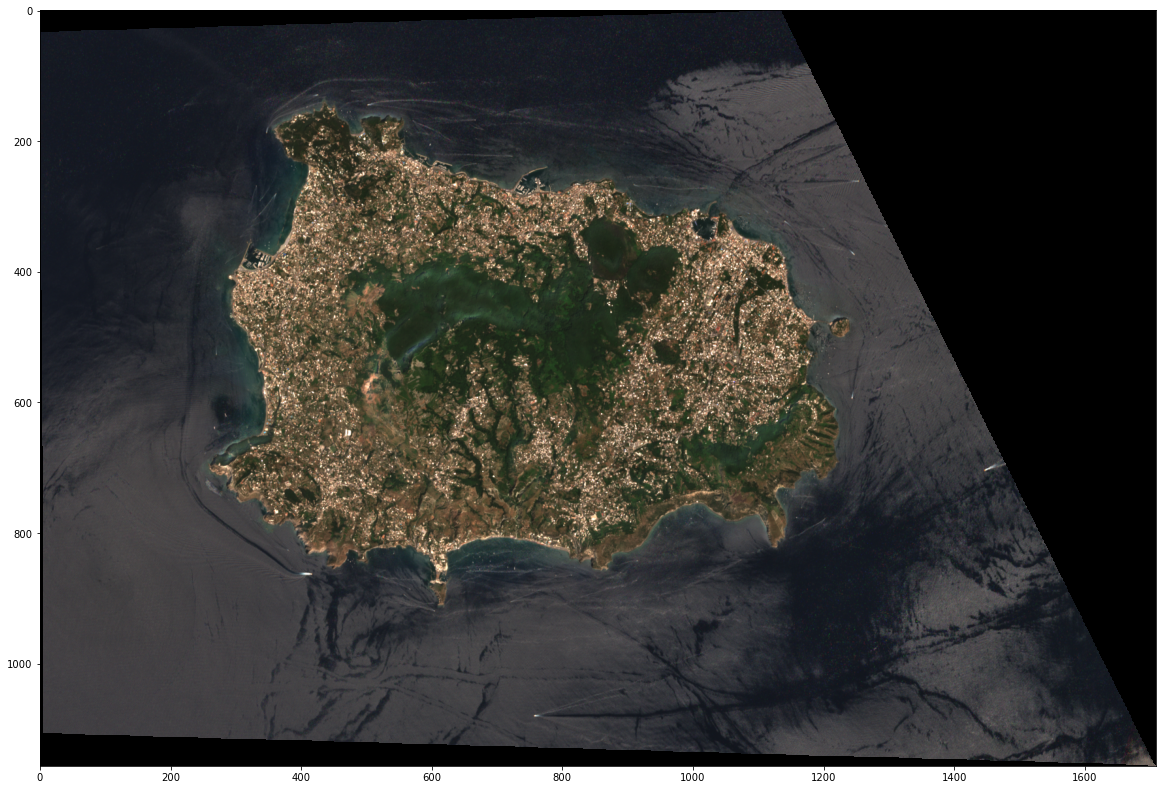

In [43]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.imshow(clipped_img)
plt.show()

## Conclusions

I tested Planetary Computer libraries in order to manage Sentinel and other products without downloading them. I performed not only the classical visualization as documentation said, but I calculated an example of NDVI and an alternative way to visualize RGB image by combining B2, B3, B4 bands and deifining a brightness and contrast function to better visualize the product. <br>Finally, the produced images are also clipped by a ROI in a geojson file format.

## References

(*)https://stackoverflow.com/questions/56905592/automatic-contrast-and-brightness-adjustment-of-a-color-photo-of-a-sheet-of-pape

(**)https://medium.com/analytics-vidhya/python-for-geosciences-satellite-image-analysis-step-by-step-6d49b1ad567